# Titanic

For this competition I will use the titanic dataset to create a predictive model that will determine whether or not each passenger survived. I've picked up a lot from the fantastic and concrete methodology displayed on [A Data Science Framework: To Achieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy "A Data Science Framework: To Achieve 99% Accuracy") which gives a detailed account of the steps taken to achieve a good score in this competition. I've decided to adopt this datascience methodology. So the first step in this process is understanding the problem.

## But not before getting stacked

In [1113]:
import pandas as pd
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
from sklearn import ensemble, discriminant_analysis, gaussian_process
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from keras import layers, models
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

## Understanding the problem

So what do we know? A supposedly unsinkable ship called the Titanic sank on the 14th April 1912. Being largely unprepared for sinkage there was a total dearth of lifeboats and women, children and the rich were prioritized over men and the poor. Being its maiden voyage and having notoriety as an unsinkable ship, the titanic also accomodated some prestigious guests who assumed 1st class compartments. The water was cold enough to kill within minutes. So the only real option was lifeboat or death. So some patterns become immediately obvious. From this information, we know a binary classification algorithm is required to determine whether passengers lived (1) or died (0) from the provided dataset.

## Gathering the Data

Easy this..

In [1114]:
train= pd.read_csv('./titanic/train.csv',delimiter=',')
test = pd.read_csv('./titanic/test.csv', delimiter=',')

## What can we glean from this?

In [1115]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [1116]:
print(train.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  


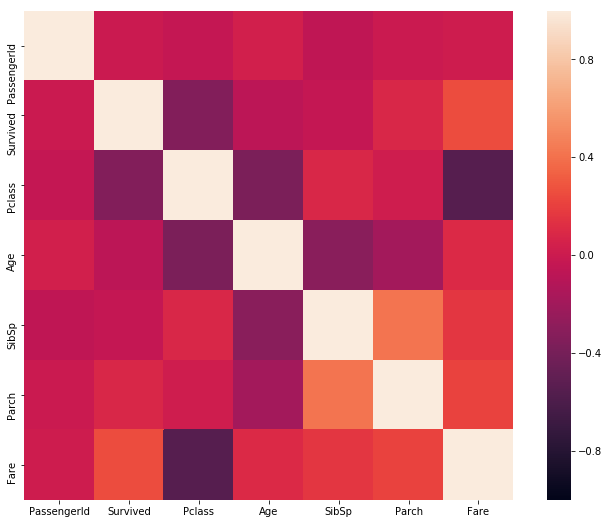

In [1117]:
correlation_matrix = train.corr()
print(train.corr())
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=1,vmin=-1,square=True)
plt.show()

In [1118]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [1119]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


As you can see from the above, a strong negative correlation was found between fare price and class. This inverse proportionality comes about from the ticket class ranking from 1 to 3 and the fare price ranking from low to high. So 1st class tickets are more expensive. The variations in price between cabins within each class would have to be taken into consideration too, as well as variations between single and family rooms. This would require looking at cabins although approxiately 3/4s of cabin entries are missing from this dataset so it may be a good idea to skip them. This is unfortunate as it could give us information about where people were relative to the point of impact of the iceburg. Additionally a positive correlation was found between Siblings and Spouses and parents and children variables but this is kind of self explanatory. 

## Variables

### PassengerId and Ticket 

These 2 variables are essentially a primary key for each row of the table and each ticket type. So this gives us no information at all. Therefore these will be dropped from the table.

### P Class

Ranks from 1 being upper to 3 being lower. 

### Gender

Male or female. Converted to dummy variable

### Age

Age of passenger.

### Name

Title + Name. Can extract title to determine whether or not this affected survival chance and subsequently drop the name column. 

### Embarked 

Port at which passenger boarded the titanic. Converted to dummy variable before fed into algorithm

### Sibsp & Parch

Number of siblings or spouses and parents & children. Used to make family size variable

### Cabin

From the above you can see there are several NaN values in the cabin column. Despite the fact the position of these cabins on the ship could be important, there are far too many missing entries to consider using this for the data set (?).

## Data Wrangling


### Supplanting null values

The median and mode should be sufficient to respectively fill the null values in Age and Embarked columns

In [1120]:
train['Age'].fillna(train['Age'].median(),inplace=True)
test['Age'].fillna(train['Age'].median(),inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
test['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)

train.drop(columns=['PassengerId','Cabin','Ticket'],inplace = True)
test.drop(columns=['Cabin','Ticket'],inplace = True)
print(train.head())
print(test.head())

   Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch     Fare Embarked  
0    male  22.0      1      0   7.2500        S  
1  female  38.0      1      0  71.2833        C  
2  female  26.0      0      0   7.9250        S  
3  female  35.0      1      0  53.1000        S  
4    male  35.0      0      0   8.0500        S  
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894 

## Feature Engineering

Adding family size and loner columns.

In [1121]:
train['Family_Size']=train['SibSp']+train['Parch']
test['Family_Size']=test['SibSp']+test['Parch']

train['Loner']=1
test['Loner']=1
train['Loner'].loc[train['Family_Size']>0]=0
test['Loner'].loc[test['Family_Size']>0]=0
train['Title']= train['Name'].str.split(', ', expand=True)[1].str.split(".", expand=True)[0]
test['Title']= test['Name'].str.split(', ', expand=True)[1].str.split(".", expand=True)[0]

train.drop(columns=['Name'],inplace=True)
test.drop(columns=['Name'],inplace=True)

print(train.head())
train_title_count=train['Title'].value_counts()<8
test_title_count=test['Title'].value_counts()<8
train['Title']=train['Title'].apply(lambda x: 'Other' if train_title_count.loc[x]==True else x)
test['Title']=test['Title'].apply(lambda x: 'Other' if test_title_count.loc[x]==True else x)

#other includes all titles bar main 4
print(train['Title'].value_counts())


   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
0         0       3    male  22.0      1      0   7.2500        S   
1         1       1  female  38.0      1      0  71.2833        C   
2         1       3  female  26.0      0      0   7.9250        S   
3         1       1  female  35.0      1      0  53.1000        S   
4         0       3    male  35.0      0      0   8.0500        S   

   Family_Size  Loner Title  
0            1      0    Mr  
1            1      0   Mrs  
2            0      1  Miss  
3            1      0   Mrs  
4            0      1    Mr  
Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: Title, dtype: int64


## Standardization

Time for a bit of visualisation. Let's investigate the distribution of fare and age fields.

0        7.2500
1       71.2833
2        7.9250
3       53.1000
4        8.0500
5        8.4583
6       51.8625
7       21.0750
8       11.1333
9       30.0708
10      16.7000
11      26.5500
12       8.0500
13      31.2750
14       7.8542
15      16.0000
16      29.1250
17      13.0000
18      18.0000
19       7.2250
20      26.0000
21      13.0000
22       8.0292
23      35.5000
24      21.0750
25      31.3875
26       7.2250
27     263.0000
28       7.8792
29       7.8958
         ...   
861     11.5000
862     25.9292
863     69.5500
864     13.0000
865     13.0000
866     13.8583
867     50.4958
868      9.5000
869     11.1333
870      7.8958
871     52.5542
872      5.0000
873      9.0000
874     24.0000
875      7.2250
876      9.8458
877      7.8958
878      7.8958
879     83.1583
880     26.0000
881      7.8958
882     10.5167
883     10.5000
884      7.0500
885     29.1250
886     13.0000
887     30.0000
888     23.4500
889     30.0000
890      7.7500
Name: Fare, Length: 891,

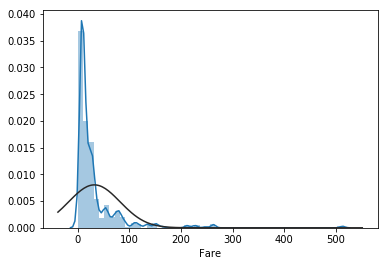

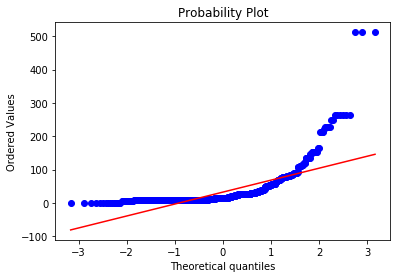

In [1122]:
print(train['Fare'])
sns.distplot(train['Fare'],fit=sp.stats.norm)
fig = plt.figure()
res = sp.stats.probplot(train['Fare'],plot=plt)
plt.show()

As you can see, the curves are far from linear and the shape of the curve far from Gaussian. In order to rectify this, I will now use logarithms to better fit this shape to a normal distribution. Note ** I did not realise this before but some zero values have popped up. I've assigned the median ticket values for each class to their corresponding zero values because of the skewness of the data.

     Survived  Pclass   Sex   Age  SibSp  Parch  Fare Embarked  Family_Size  \
179         0       3  male  36.0      0      0   0.0        S            0   
263         0       1  male  40.0      0      0   0.0        S            0   
271         1       3  male  25.0      0      0   0.0        S            0   
277         0       2  male  28.0      0      0   0.0        S            0   
302         0       3  male  19.0      0      0   0.0        S            0   
413         0       2  male  28.0      0      0   0.0        S            0   
466         0       2  male  28.0      0      0   0.0        S            0   
481         0       2  male  28.0      0      0   0.0        S            0   
597         0       3  male  49.0      0      0   0.0        S            0   
633         0       1  male  28.0      0      0   0.0        S            0   
674         0       2  male  28.0      0      0   0.0        S            0   
732         0       2  male  28.0      0      0   0.

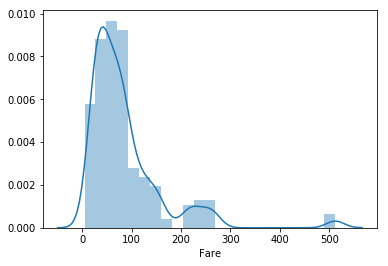

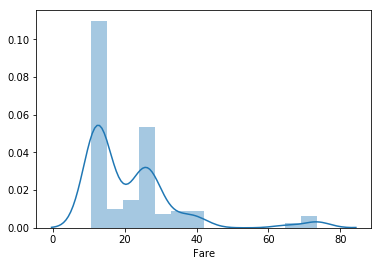

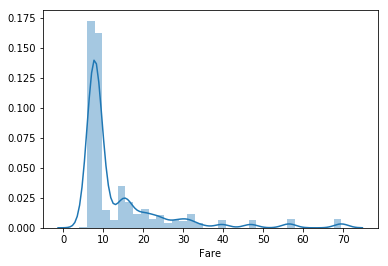

           Fare
Pclass         
1       61.9792
2       15.0229
3        8.0500
Empty DataFrame
Columns: [Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, Family_Size, Loner, Title]
Index: []
Empty DataFrame
Columns: [PassengerId, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, Family_Size, Loner, Title]
Index: []
0        7.2500
1       71.2833
2        7.9250
3       53.1000
4        8.0500
5        8.4583
6       51.8625
7       21.0750
8       11.1333
9       30.0708
10      16.7000
11      26.5500
12       8.0500
13      31.2750
14       7.8542
15      16.0000
16      29.1250
17      13.0000
18      18.0000
19       7.2250
20      26.0000
21      13.0000
22       8.0292
23      35.5000
24      21.0750
25      31.3875
26       7.2250
27     263.0000
28       7.8792
29       7.8958
         ...   
861     11.5000
862     25.9292
863     69.5500
864     13.0000
865     13.0000
866     13.8583
867     50.4958
868      9.5000
869     11.1333
870      7.8958
871     52.5542
872

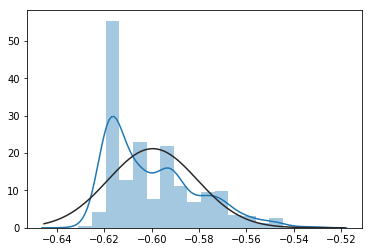

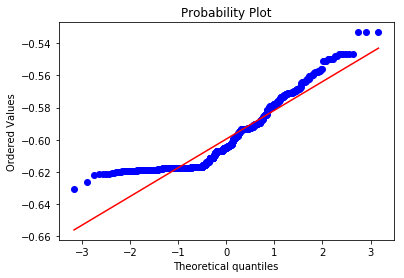

In [1123]:
zeros = train.loc[train['Fare']==0]
test_zeros = test.loc[test['Fare']==0]
print(zeros)
## NO ZERO VALUES IN TEST FOR FARE
print(test_zeros)
filter_columns = train[['Pclass','Fare']]
filter_free_tickets = filter_columns[filter_columns['Fare']>0]
class_groups = filter_free_tickets.groupby('Pclass')

for name,group in class_groups:
    sns.distplot(group['Fare'])
    plt.show()

class_groups_median= class_groups.median()
print(class_groups_median)
def col_change(x,y):
    if x==0:
        return class_groups_median.iloc[y-1]['Fare']
    else:
        return x
train['Fare']=train.apply(lambda x: col_change(x['Fare'],x['Pclass']), axis=1)
test['Fare']=test.apply(lambda x: col_change(x['Fare'],x['Pclass']),axis=1)
#     test['Fare']=test['Fare'].apply(lambda x: class_groups_median.iloc[i+1,0] if x==0 else x)
new_zeros = train.loc[train['Fare']==0]
new_test_zeros=test.loc[test['Fare']==0]
print(new_zeros)
print(new_test_zeros)
print(train['Fare'])
fare_mean = train['Fare'].mean()
fare_std = train['Fare'].std()
test['Fare']=test['Fare'].apply(lambda x: np.log(x))
test['Fare']-=fare_mean
test['Fare']/=fare_std
train['Fare']=train['Fare'].apply(lambda x: np.log(x))
train['Fare']-=fare_mean
train['Fare']/=fare_std
print(class_groups_median)
sns.distplot(train['Fare'].to_numpy(),fit=sp.stats.norm)
fig = plt.figure()
res = sp.stats.probplot(train['Fare'],plot=plt)
plt.show()

Now the same again for age

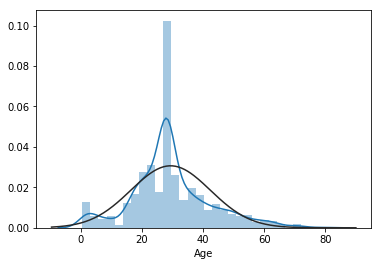

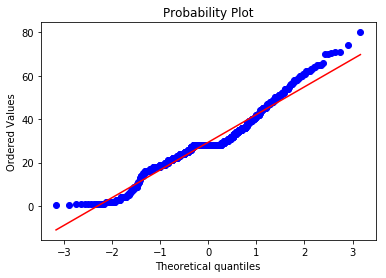

In [1124]:
sns.distplot(train['Age'],fit=sp.stats.norm)
fig = plt.figure()
res = sp.stats.probplot(train['Age'],plot=plt)
plt.show()

As you can see age is almost a normal distribution already. Let's see what normalizing this will do

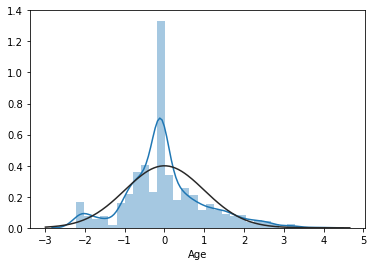

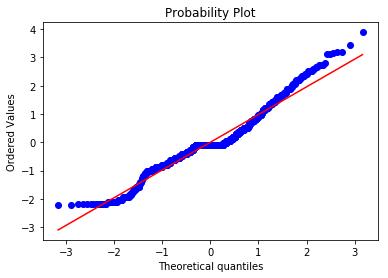

In [1125]:
age_mean = train['Age'].mean()
age_std = train['Age'].std()
train['Age']-=age_mean
train['Age']/=age_std
test['Age']-=age_mean
test['Age']/=age_std
sns.distplot(train['Age'],fit=sp.stats.norm)
fig = plt.figure()
res = sp.stats.probplot(train['Age'],plot=plt)
plt.show()

## Standardize categorical data

Ez pz

In [1126]:
train=pd.get_dummies(train)
train=pd.get_dummies(train, columns=['Pclass'])
test=pd.get_dummies(test)
test=pd.get_dummies(test,columns=['Pclass'])
print(train.head())

   Survived       Age  SibSp  Parch      Fare  Family_Size  Loner  Sex_female  \
0         0 -0.565419      1      0 -0.618974            1      0           0   
1         1  0.663488      1      0 -0.572903            1      0           1   
2         1 -0.258192      0      0 -0.617180            0      1           1   
3         1  0.433068      1      0 -0.578839            1      0           1   
4         0  0.433068      0      0 -0.616864            0      1           0   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  Title_Master  Title_Miss  \
0         1           0           0           1             0           0   
1         0           1           0           0             0           0   
2         0           0           0           1             0           1   
3         0           0           0           1             0           0   
4         1           0           0           1             0           0   

   Title_Mr  Title_Mrs  Title_Other  Pclass_1  Pcl

Now split into training and validation data. Going to go for approximately 75/25 train/validation split.

In [1127]:
train_y = train['Survived']
# le = LabelEncoder()
# train_y = to_categorical(train_y)
train.drop(['Survived'],axis=1, inplace=True)
train=train.to_numpy()

## Model Data

Now to pick an ensemble of machine learning algorithms to model the data. For this I will pick an XGBoost classifier, a random tree classifier, an SVC and a keras neural net with K-means validation.

### Support Vector Machine

Creates a boundary between datapoints based on their classifications. This works by maximizing the distance between the dividing/classification line and the support vectors. This distance is called the margin. The support vectors are the points that lie closest to the line. For n features there will be at least n+1 support vectors. Since outliers can occur, and decrease the size of the margin an error value is often added as the 'c' parameter in the SVC algorithm. Along with the kernel which determines the nature of the classification line (polynomial or linear), this makes up the main features of the support vector classifier. Too high a value of c can lead to overfitting. Underfitting occurs when is left at 0 with outliers present. Changing the kernel to polynomial and adding a degree of 2 will assume a quadratic input and transform all input points into the form (x,y)-->(2^0.5*x*y,x^2,y^2) which linearizes in 3D by adding an additional dimension. So basically it adds additional dimensions to make the data points linearly separable. SVC default rbf (radial basis function) kernel separates inputs into an infinite number of dimensions! Tweak the gamma function to adjust the error margin around rbf to guarantee the best fit to your data. Maths of SVM coming soon! This is the results achieved by optimizing on rbf kernel.

#processing model # 0
0.8215488215488216
processing model # 1
0.8316498316498316
processing model # 2
0.8417508417508418
val_acc = 0.86
val_loss = 0.14

Not badddd...

### Decision Tree

Decision trees are greedy algorithms where data is classified using a tree which is created by splitting on the features which best classify the data. Repeat this process until all features are used. Each bit of data is then passed down this tree and classified based on the stats given. Each point at which classification occurs is called a leaf; a point where the data stops splitting at a point.

The Gini impurity enables you to quantify the probability that a data point will be incorrectly classified at each node of the decision tree. This Gini impurity is calculated by subtracting the squared fractions of the labels that make up the data that has not yet been classified.

1-tot(fr^2) = GI

So if a dataset consisted of only 1 class, you'd have a GI of 0.

The information gain is the difference in impurity before and after a split in the tree.

Information gain = GI before split - total GI after split

So all values of inequalities will be optimized to give the largest information gain at each step. The optimum feature to split on at each stage will be determined by this information gain as well as features not to split on! An information gain of 0 is useless.

The size of the subsets is very important too. This means the data should be weighted dependant on how much data is classified. 
total GI after split = tot(%age_of_points_classified*GI)

This can be used recursively to build the tree that will classify the data required. Due to the methodology described here, this means the same tree will be created every time.

processing model # 0
0.7306397306397306
processing model # 1
0.7777777777777778
processing model # 2
0.7676767676767676

val_acc = 0.98.2
val_loss = 0.018

What the hell? This cannot be right.. why is this so damn accurate?!

This is due to overfitting - the tree needs to be pruned so it does not adapt too much to the training data. This involves shrinking the size of the tree. Validation accuracy maximized on a maximum depth of 4!

processing model # 0
0.8181818181818182
processing model # 1
0.8013468013468014
processing model # 2
0.8215488215488216

BETTER!!!

val_acc=0.8383838383838383
val_loss=0.16161616161616163

More realistic!
### Random Forest

A random forest is an ensemble technique that consists of a collection of decision trees that come together to classify data. They essentially return the mode of each decision tree's classification. This overcomes the problem of overfitting which occurs in the standalone decision trees. Although from the previous decision tree's accuracy, not a problem at all!!

So a random forest creates trees via a process called bagging which relies on a different subset of the training data each time. The rows of the data are randomly selected with replacement. The tree can also be bagged on features. A rule of thumb is to randomly select $ \sqrt n $ features to be chosen from at each split in the tree.

So with an ensemble of ensembles the results come back as follows

processing model # 0
0.8215488215488216
processing model # 1
0.835016835016835
processing model # 2
0.835016835016835

0.835016835016835
0.16498316498316498

Hmm not so good!

However with a single ensemble encompassing the entire training set (80:20 split)

val_acc=0.8603351955307262

We achieve much better results


### Gradient Boost

Machine learning algorithm that creates an ensemble network

### XGBoost

Ensemble method that creates many unique trees to make a prediction.

1. A prediction is made for line that best fits the data
2. THis prediction is then added to the previous prediction (added to 0 if no prediction made)
3. The residuals between datapoints and line are then calculated
4. A regression tree is built to generate a new predition for the residuals.
5. This residual for the values in each node are then multiplied by the learning rate and added to the previous prediction.
6. Repeating this process generates a series of weak learners


In [1128]:
def build_model():
    model= models.Sequential()
    model.add(layers.Dense(32,activation='relu',input_shape=(train.shape[1],)))
#     model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model
# k=4
# num_samples = len(train)//k
# num_epochs = 18
# ensemble = []
# val_data = train[0:200]
# val_targets = train_y[0:200]
# train_data = train[200:len(train)]
# train_targets = train_y[200:len(train_y)]
for i in range(k):
    print('processing model #',i)
    val_data = train[i* num_samples: (i+1)* num_samples]
    val_targets = train_y[i* num_samples: (i+1)* num_samples]

    partial_train_data = np.concatenate(
        [train[:i*num_samples],
        train[(i+1)* num_samples:]],axis=0
    )
    partial_train_targets = np.concatenate(
        [train_y[:i*num_samples],
        train_y[(i+1)* num_samples:]],
        axis=0
    )
    dtrain = xgb.DMatrix(partial_train_data,partial_train_targets)
    dval = xgb.DMatrix(val_data,val_targets)
#     dtrain = xgb.DMatrix(train_data,train_targets)
#     dval = xgb.DMatrix(val_data,val_targets)
    eval_list = [(dval,'eval'),(dtrain,'train')]
    num_round = 25
    params = {
             'max_depth': 4, #maximum number of levels in decision tree
             'objective': 'binary:logistic', #determines loss function used
             'eta':0.125, #learning rate
             'min_child_weight':1, #minimum similarity score for each leaf. if similarity score of leaf<min_child_weight then this leaf will not be included,
             'gamma':1, #added to denominator of loss function to decrease similirity score of leaves to prevent overfitting',
             'delta': 0.75, #L2 regularization term - Ridge regression. Penalizes high slope values as sensitivity to error increases with slope. good when 
             'alpha': 0.4, #L1 regularization term - Lasso regression. Shrinks less important feature coefficients to zero so useful when unnecessarily large number of features
             'eval_metric': 'error',
             'colsample_bytree': 0.8,
            

            }
    bst = xgb.train(params,dtrain,num_round,eval_list,early_stopping_rounds=20)
    pickle.dump(bst,open('xgb'+ str(i) + '.pickle.dat','wb'))
    loaded_model = pickle.load(open("xgb"+str(i)+".pickle.dat", "rb"))
    accuracy = loaded_model.predict(dval,ntree_limit=bst.best_ntree_limit)
    classifications = [0 if x<=0.5 else 1 for x in accuracy ]

    correct = [True if x==y else False for (x,y) in zip(classifications,val_targets)]
    fraction = correct.count(True)/len(correct)
    print(classifications)
    print(val_targets)
    print(fraction)
    ensemble.append(loaded_model)



processing model # 0
[0]	eval-error:0.153153	train-error:0.177877
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 20 rounds.
[1]	eval-error:0.162162	train-error:0.165919
[2]	eval-error:0.162162	train-error:0.165919
[3]	eval-error:0.162162	train-error:0.153961
[4]	eval-error:0.148649	train-error:0.153961
[5]	eval-error:0.153153	train-error:0.150972
[6]	eval-error:0.175676	train-error:0.140508
[7]	eval-error:0.171171	train-error:0.139013
[8]	eval-error:0.171171	train-error:0.139013
[9]	eval-error:0.175676	train-error:0.140508
[10]	eval-error:0.171171	train-error:0.139013
[11]	eval-error:0.171171	train-error:0.142003
[12]	eval-error:0.171171	train-error:0.140508
[13]	eval-error:0.171171	train-error:0.139013
[14]	eval-error:0.162162	train-error:0.133034
[15]	eval-error:0.171171	train-error:0.130045
[16]	eval-error:0.166667	train-error:0.13154
[17]	eval-error:0.166667	train-error:0.127055
[18]	eval-error

[7]	eval-error:0.148649	train-error:0.136024
[8]	eval-error:0.148649	train-error:0.136024
[9]	eval-error:0.148649	train-error:0.137519
[10]	eval-error:0.153153	train-error:0.136024
[11]	eval-error:0.153153	train-error:0.134529
[12]	eval-error:0.157658	train-error:0.134529
[13]	eval-error:0.157658	train-error:0.137519
[14]	eval-error:0.157658	train-error:0.133034
[15]	eval-error:0.162162	train-error:0.136024
[16]	eval-error:0.162162	train-error:0.136024
[17]	eval-error:0.162162	train-error:0.136024
[18]	eval-error:0.162162	train-error:0.136024
[19]	eval-error:0.162162	train-error:0.136024
[20]	eval-error:0.153153	train-error:0.12855
[21]	eval-error:0.157658	train-error:0.133034
[22]	eval-error:0.157658	train-error:0.13154
[23]	eval-error:0.157658	train-error:0.13154
[24]	eval-error:0.157658	train-error:0.13154
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0

In [1129]:
ensemble = np.array(ensemble)
# indices = np.random.choice(range(0,891),200,replace=False)
# val_dat = []
# val_labels= []
# for i in indices:
#     val_dat.append(train[i])
#     val_labels.append(train_y[i])
passenger_id = test['PassengerId']
test.drop(['PassengerId'],axis=1,inplace=True)

test = test.to_numpy()
print(test[0:5])
final_predictions = []
# for i in range(len(val_dat)):
#     predictions = []
#     for model in ensemble:
#         dval = xgb.DMatrix([val_dat[i]],[val_labels[i]])
#         predict = model.predict(dval)
#         print(predict)
#         prediction = predict[0]
#         if prediction <=0.5:
#             predictions.append(0)
# #         int_prediction = predict[0].tolist().index(prediction)
#         else:
#             predictions.append(1)
#     most_votes = sp.stats.mode(predictions)
#     print(val_labels[i])
#     print(most_votes)
    
#     print(val_labels[i]==most_votes[0][0])
#     if val_labels[i]==most_votes[0][0]:
#         final_predictions.append(True)
#     else:
#         final_predictions.append(False)
for i in range(len(test)):
    predictions = []
    for model in ensemble:
        dtest = xgb.DMatrix([test[i]])
        predict = model.predict(dtest)
        prediction = predict[0]
        if prediction <=0.5:
            predictions.append(0)
#         int_prediction = predict[0].tolist().index(prediction)
        else:
            predictions.append(1)
    most_votes = sp.stats.mode(predictions)
    final_predictions.append([passenger_id[i],most_votes[0][0]])
# val_acc = final_predictions.count(True) / len(final_predictions)
# val_loss = final_predictions.count(False) / len(final_predictions)
# print(val_acc)
# print(val_loss)
# print(test)
# print(train)
print(len(final_predictions))
submission = pd.DataFrame(data=np.array(final_predictions), columns=['PassengerId','Survived'])
print(submission.head())

[[ 0.39466492  0.          0.         -0.61742484  0.          1.
   0.          1.          0.          1.          0.          0.
   0.          1.          0.          0.          0.          0.
   1.        ]
 [ 1.35474874  1.          0.         -0.61968137  1.          0.
   1.          0.          0.          0.          1.          0.
   0.          0.          1.          0.          0.          0.
   1.        ]
 [ 2.50684932  0.          0.         -0.61313197  0.          1.
   0.          1.          0.          1.          0.          0.
   0.          1.          0.          0.          0.          1.
   0.        ]
 [-0.18138537  0.          0.         -0.61538614  0.          1.
   0.          1.          0.          0.          1.          0.
   0.          1.          0.          0.          0.          0.
   1.        ]
 [-0.5654189   1.          1.         -0.60833983  2.          0.
   1.          0.          0.          0.          1.          0.
   0.          0

In [1130]:
submission.to_csv('results.csv',index=False, header=['PassengerId','Survived'])